# Day 3 API (bonus)
This notebook demonstrates how to use the Hugging Face and Open AI API to classify text as neutral or partisan. The main benefit of the API is that it allows us to run the latest, largest models without having the specialised hardware needed to run them (since the models are run on the cloud). We will use the `meta-llama/Meta-Llama-3-70B-Instruct` model from Hugging Face and the `gpt-4o` model from Open AI. The downside is that the API is not (always) free.

## Environment Setup

In [ ]:
import sys
if 'google.colab' in sys.modules:  # If in Google Colab environment
    # Mount google drive to enable access to data files
    from google.colab import drive
    drive.mount('/content/drive')
    
    # Installing requisite packages
    !pip install transformers openai  &> /dev/null

    # Change working directory to day_3
    %cd /content/drive/MyDrive/LLM4BeSci_GSERM2024/day_3

The code begins by loading some general libraries, the zero-shot prompt, and the same `media_bias_test.csv` file as in `day_3a.ipynb`. The goal will again be to classify the tweet as either `'neutral'` or `'partisan'`.  We will this time only use zero-shot classification, however the code can be easily adapted to few-shot as in `day_3a.ipynb`. 

In [25]:
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm_notebook as tqdm

In [26]:
media_bias_test = pd.read_csv('media_bias_test.csv')
media_bias_test

,author,text,bias,type,audience
0,Dina Titus (Representative from Nevada),"#FMLA has been helping families for 20 years, ...",neutral,support,national
1,Tim Griffin (Representative from Arkansas),"Join me for another ""#SweetTea with Tim"" in #S...",neutral,media,national
2,Alan Grayson (Representative from Florida),The Original Chickenhawk. http://t.co/gqThSecLxB,neutral,policy,national
3,Michelle Lujan Grisham (Representative from Ne...,Like my @facebook page for updates on how I'm ...,neutral,mobilization,constituency
4,Dean Heller (Senator from Nevada),@NevadaWolfPack's own @Kaepernick7 = Best Brea...,neutral,personal,constituency
...,...,...,...,...,...
95,Andy Harris (Representative from Maryland),13k plans at risk RT @ReutersUS: Aetna exits O...,partisan,information,national
96,Doug Collins (Representative from Georgia),"Targeting conservatives by day, partying by ni...",partisan,policy,national
97,David Schweikert (Representative from Arizona),Great talk earlier tonight w/@TheKudlowReport....,partisan,policy,national
98,Joe Barton (Representative from Texas),"President calls for ""modern pipelines."" What a...",partisan,attack,national


In [27]:
zero_shot_prompt = "Is this text neutral or partisan? Strictly answer with only 'neutral' or 'partisan':\n"

## Hugging Face API

In order to use the Hugging Face API, you will need to follow the following steps:

1.  Make sure you have a hugging Face account (https://huggingface.co/join)
2. Go to the [Llama-3 model page](https://huggingface.co/meta-llama/Meta-Llama-3-70B-Instruct) and fill in the 'META LLAMA 3 COMMUNITY LICENSE AGREEMENT' form at the top of the page in order to get access to the model (this may take a few days). 
3. Once you have been granted access, you can navigate to [in your Hugging Face profile settings](https://huggingface.co/settings/tokens) to get the model's API access token. This token should provide access to all models in the Llama family. 
4. If you wish to run the largest (70B parameter) version of Llama-3, you will need to have a Hugging Face PRO subscription (currently $9/month). You can also run the smaller versions for free.

The Hugging Face API code begins importing the `InferenceClient` class from the `huggingface_hub` library. The `InferenceClient` provides a high-level API to interact with models hosted on the Hugging Face Hub. 

In [28]:
from huggingface_hub import InferenceClient

The code next initializes the `InferenceClient` with the access token, *which you will need to replace with your own access token* (access tokens start with 'hf_...') it then loops through the tweets in the `media_bias_test` dataframe just as in `day_3a.ipynb`. The code then generates the output using the `chat_completion` method of the `InferenceClient` class. This allows us to play around with certain generation-related parameters such as `max_tokens` and `temperature`. 

The output is then parsed to extract the label, which is then appended to the `zero_shot_labels` list. The code then adds the `zero_shot_labels` list to the `media_bias_test` dataframe.

In [29]:
# Initialize client
api_key = '<your access token here>' 
client = InferenceClient(token=api_key)

zero_shot_labels = []
for tweet in tqdm(media_bias_test['text']):    
    
    # Zero-shot classification 
    output = client.chat_completion(
        messages=[{"role": "user", "content": zero_shot_prompt + tweet}],
        model="meta-llama/Meta-Llama-3-70B-Instruct",
        max_tokens=100,
        temperature=0.0
    ).choices[0].message.content.lower()
    
    # Extract label and append to list
    label = 'neutral' if 'neutral' in output else 'partisan' if 'partisan' in output else 'nan' # 
    zero_shot_labels.append(label)

# Add zero-shot labels to dataframe
media_bias_test['zero_shot_label'] = zero_shot_labels
media_bias_test

  0%|          | 0/100 [00:00<?, ?it/s]

partisan
---------------------
neutral
---------------------
partisan
---------------------
partisan
---------------------
neutral
---------------------
neutral
---------------------
partisan
---------------------
partisan
---------------------
neutral
---------------------
neutral
---------------------
neutral
---------------------
partisan
---------------------
neutral
---------------------
neutral
---------------------
neutral
---------------------
neutral
---------------------
neutral
---------------------
neutral
---------------------
neutral
---------------------
partisan
---------------------
neutral
---------------------
partisan
---------------------
neutral
---------------------
neutral
---------------------
partisan
---------------------
neutral
---------------------
partisan
---------------------
neutral
---------------------
neutral
---------------------
neutral
---------------------
partisan
---------------------
neutral
---------------------
partisan
--------------------

,author,text,bias,type,audience,zero_shot_label
0,Dina Titus (Representative from Nevada),"#FMLA has been helping families for 20 years, ...",neutral,support,national,partisan
1,Tim Griffin (Representative from Arkansas),"Join me for another ""#SweetTea with Tim"" in #S...",neutral,media,national,neutral
2,Alan Grayson (Representative from Florida),The Original Chickenhawk. http://t.co/gqThSecLxB,neutral,policy,national,partisan
3,Michelle Lujan Grisham (Representative from Ne...,Like my @facebook page for updates on how I'm ...,neutral,mobilization,constituency,partisan
4,Dean Heller (Senator from Nevada),@NevadaWolfPack's own @Kaepernick7 = Best Brea...,neutral,personal,constituency,neutral
...,...,...,...,...,...,...
95,Andy Harris (Representative from Maryland),13k plans at risk RT @ReutersUS: Aetna exits O...,partisan,information,national,neutral
96,Doug Collins (Representative from Georgia),"Targeting conservatives by day, partying by ni...",partisan,policy,national,partisan
97,David Schweikert (Representative from Arizona),Great talk earlier tonight w/@TheKudlowReport....,partisan,policy,national,neutral
98,Joe Barton (Representative from Texas),"President calls for ""modern pipelines."" What a...",partisan,attack,national,partisan


As you can see, the accuracy of  `'Meta-Llama-3-70B-Instruct'` is roughly on par with `'Phi-3-mini-128k-instruct'` from `day_3a.ipynb`. This demonstrates that the larger model does not always outperform the smaller one:

In [31]:
# Comparing zero-shot and actual labels
print(f'Zero-shot accuracy: {(media_bias_test["zero_shot_label"] == media_bias_test["bias"]).mean()}')

Zero-shot accuracy: 0.67


<Axes: xlabel='zero_shot_label', ylabel='bias'>

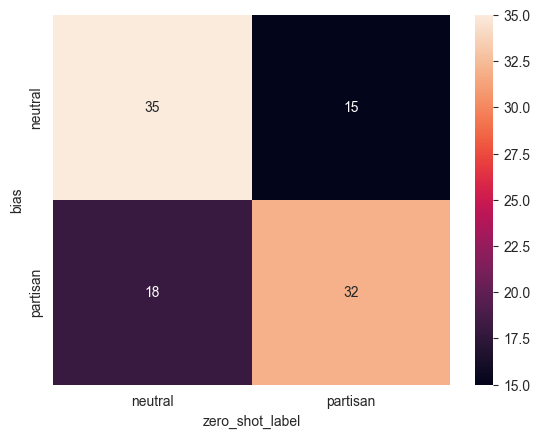

In [32]:
# Confusion matrix
confusion = pd.crosstab(media_bias_test['bias'], media_bias_test['zero_shot_label'])
sns.heatmap(confusion, annot=True)

**TASK 1**: Try playing around with different `temperature` values (e.g. 0.5, 1.0, and 3.0) and see how it affects the accuracy.

## Open AI API
We now demonstrate how to do the same as the above using Open AI API. In order to use the Open AI API, you will need to follow the following steps:

1. [Create an Open AI account](https://platform.openai.com/signup)
2. Navigate to your Profile's [billing page](https://platform.openai.com/settings/organization/billing/overview) and add some funds to your account (the minimum of $5 will be more than enough for this task).
3. Navigate to your Profile's [API keys page](https://platform.openai.com/api-keys) and create a new API key.

The code begins by importing the `OpenAI` class from the `openai` library. The `OpenAI` class provides a high-level API to interact with models hosted on the Open AI platform.

In [33]:
from openai import OpenAI

The code next initializes the `OpenAI` class with the API key, *which you will need to replace with your own API key*. The code then generates the output using the `chat.completions.create` method of the `OpenAI` class. This allows us to play around with certain generation-related parameters such as `max_tokens` and `temperature`.

In [35]:
# Initialize client
api_key = '<your api key here>'
client = OpenAI(api_key=api_key)

zero_shot_labels = []
for tweet in tqdm(media_bias_test['text']):
    
    # Zero-shot classification
    output = client.chat.completions.create(
        messages=[{"role": "user", "content": zero_shot_prompt + tweet}],
        model="gpt-4o",
        max_tokens=10,
        temperature=0.0
    ).choices[0].message.content.lower()
    
    # Extract label and append to list
    label = 'neutral' if 'neutral' in output else 'partisan' if 'partisan' in output else 'nan' # 
    zero_shot_labels.append(label)

media_bias_test['zero_shot_label'] = zero_shot_labels
media_bias_test

  0%|          | 0/100 [00:00<?, ?it/s]

partisan
---------------------
neutral
---------------------
partisan
---------------------
neutral
---------------------
neutral
---------------------
neutral
---------------------
partisan
---------------------
partisan
---------------------
neutral
---------------------
neutral
---------------------
neutral
---------------------
partisan
---------------------
neutral
---------------------
neutral
---------------------
neutral
---------------------
neutral
---------------------
neutral
---------------------
neutral
---------------------
neutral
---------------------
partisan
---------------------
neutral
---------------------
partisan
---------------------
neutral
---------------------
neutral
---------------------
partisan
---------------------
neutral
---------------------
partisan
---------------------
neutral
---------------------
neutral
---------------------
neutral
---------------------
partisan
---------------------
neutral
---------------------
partisan
---------------------

,author,text,bias,type,audience,zero_shot_label
0,Dina Titus (Representative from Nevada),"#FMLA has been helping families for 20 years, ...",neutral,support,national,partisan
1,Tim Griffin (Representative from Arkansas),"Join me for another ""#SweetTea with Tim"" in #S...",neutral,media,national,neutral
2,Alan Grayson (Representative from Florida),The Original Chickenhawk. http://t.co/gqThSecLxB,neutral,policy,national,partisan
3,Michelle Lujan Grisham (Representative from Ne...,Like my @facebook page for updates on how I'm ...,neutral,mobilization,constituency,neutral
4,Dean Heller (Senator from Nevada),@NevadaWolfPack's own @Kaepernick7 = Best Brea...,neutral,personal,constituency,neutral
...,...,...,...,...,...,...
95,Andy Harris (Representative from Maryland),13k plans at risk RT @ReutersUS: Aetna exits O...,partisan,information,national,partisan
96,Doug Collins (Representative from Georgia),"Targeting conservatives by day, partying by ni...",partisan,policy,national,partisan
97,David Schweikert (Representative from Arizona),Great talk earlier tonight w/@TheKudlowReport....,partisan,policy,national,partisan
98,Joe Barton (Representative from Texas),"President calls for ""modern pipelines."" What a...",partisan,attack,national,partisan


As you can see, the accuracy of  `'gpt-4o'` is considerably better than `'Meta-Llama-3-70B-Instruct'` and `'Phi-3-mini-128k-instruct'`, now at 73%:

In [37]:
# Comparing zero-shot and actual labels
print(f'Zero-shot accuracy: {(media_bias_test["zero_shot_label"] == media_bias_test["bias"]).mean()}')

Zero-shot accuracy: 0.73


<Axes: xlabel='zero_shot_label', ylabel='bias'>

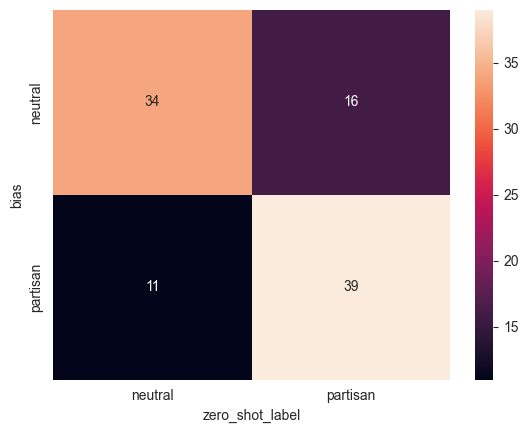

In [38]:
# Confusion matrix
confusion = pd.crosstab(media_bias_test['bias'], media_bias_test['zero_shot_label'])
sns.heatmap(confusion, annot=True)

**TASK 1**: Again try playing around with different `temperature` values (e.g. 0.5, 1.0, and 3.0) and see how it affects the accuracy.
**TASK 2**: Try adapting the code from `day_3a.ipynb` to use few-shot classification instead of zero-shot classification. Does accuracy improve?